In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2


import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
import utils
import plotting

import os


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Create ISORROPIA Input

In [13]:
#import HEMCO emissions files and choose the first level, combine into one dataset
ds_nonuc = xr.open_zarr('./pm_nonuc_ds.zarr')
ds_normal = xr.open_zarr('../model_validation/pm_ds.zarr')
ds_normal = ds_normal.sel(model_name = 'MODEL').drop('model_name')
ds = xr.concat([ds_nonuc, ds_normal], pd.Index(['no_nuclear', 'normal'], name='model_name'))

#import RH and T dataframe
RH_T_df = pd.read_csv('RH_T.csv', index_col=[0,1])

#subset our ds into just the species we need
species_list = ['SO4','NH3','HNO3']
isorropia_ds = ds[species_list]

SO4, NH3, NO3, Cl, Ca, K, Mg

In [14]:
#create a dataframe for our isorropia monthly mean values for no nuclear and normal cases, indexed by species, location, season

isorropia_dict = {}
for species in species_list:
    isorropia_dict[species]= {}
    for region in utils.lat_lon_dict.keys():
        isorropia_dict[species][region] = {}
        for season in ['DJF','MAM','JJA','SON']:
            data = isorropia_ds.sel(lon = slice(utils.lat_lon_dict[region][0], utils.lat_lon_dict[region][1]), 
                                    lat = slice(utils.lat_lon_dict[region][2],utils.lat_lon_dict[region][3])).groupby('time.season').mean(dim = ['lat','lon','time']).sel(season = season)[species]
            isorropia_dict[species][region][season] = data.values
            
isorropia_df = pd.DataFrame.from_dict({(i,j,k): isorropia_dict[i][j][k] 
                            for i in isorropia_dict.keys() 
                            for j in isorropia_dict[i].keys()
                            for k in isorropia_dict[i][j].keys()},
                            orient='index', columns = ['no_nuclear','normal'])

isorropia_df.index = pd.MultiIndex.from_tuples(isorropia_df.index, names = ['Species','Location', 'Season'])

In [15]:
#convert from mol/mol to mol/m3 by multiplying by P/T*R (mol/m3)
stp_p = 101325 #Pa = kg/m/s^2
R = 8.314 #J/K/mol
isorropia_df['no_nuclear_2x'] = '0'
for species in species_list:
    for region in utils.lat_lon_dict.keys():
            for season in ['DJF','MAM','JJA','SON']:
                isorropia_df.loc[(species,region,season)]['no_nuclear'] *= stp_p/R/RH_T_df.loc[(region,season)]['T']
                isorropia_df.loc[(species,region,season),'no_nuclear_2x'] = 2 * isorropia_df.loc[(species,region,season)]['no_nuclear']
                isorropia_df.loc[(species,region,season)]['normal'] *= stp_p/R/RH_T_df.loc[(region,season)]['T']
                isorropia_df.loc[(species,region,season),'normal_2x'] = 2 * isorropia_df.loc[(species,region,season)]['normal']

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


## Run through ISORROPIA
### Only run once to initiate a new ISORROPIA output, otherwise, the output is already made

os.chdir('../../ISORROPIAIIStandalone')
for model in ['no_nuclear', 'normal']:
    for region in ['SE_lat_lon', 'NW_lat_lon', 'NE_lat_lon', 'MW_lat_lon', 'SW_lat_lon']:
            for season in ['DJF','JJA']:
                T_tmp = RH_T_df.loc[(region, season)]['T']
                RH_tmp = RH_T_df.loc[(region, season)]['RH']
                isorropia_tmp = isorropia_df.loc[('NH3', region, season)][model]
                
                os.system(f'mkdir -p {region}_{season}_{model}/')
                os.system(f'cp src/* {region}_{season}_{model}/')
                
                os.chdir(f'{region}_{season}_{model}/')
                print(os.listdir())
                
                cmdprefix = 'cat ISORange.dat | sed -i '
                cmdT = f"-e 's/T(K):       0.0/T(K):       {T_tmp}/' "
                cmdRH = f"-e 's/RH(-):      0.0/RH(-):      {RH_tmp}/' "
                cmdNH3 = f"-e 's/TNH3:       0.0/TNH3:       {isorropia_tmp}/' "
                cmdoutput = f"-e 's/Output:     NW_DJF_nonuc_ISOOutput.nc/Output:     ISOOutput_{region}_{season}_{model}.nc/' "
                cmdsuffix = 'ISORange.dat'
                
                cmd = cmdprefix+cmdT+cmdRH+cmdNH3+cmdoutput+cmdsuffix
                
                os.system(cmd)
                
                os.chdir('../')

os.chdir('../grid_model/ego_nonuclear_project/')

## Look at ISORROPIA Outputs

In [18]:
model = 'normal'

MW_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_MW_lat_lon_DJF_{model}.nc'
MW_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_MW_lat_lon_JJA_{model}.nc'

SW_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_SW_lat_lon_DJF_{model}.nc'
SW_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_SW_lat_lon_JJA_{model}.nc'

NW_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_NW_lat_lon_DJF_{model}.nc'
NW_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_NW_lat_lon_JJA_{model}.nc'

SE_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_SE_lat_lon_DJF_{model}.nc'
SE_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_SE_lat_lon_JJA_{model}.nc'

NE_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_NE_lat_lon_DJF_{model}.nc'
NE_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_NE_lat_lon_JJA_{model}.nc'

ds_MW = utils.open_ISORROPIA(MW_DJF, MW_JJA, 'MW')
ds_NE = utils.open_ISORROPIA(NE_DJF, NE_JJA, 'NE')
ds_NW = utils.open_ISORROPIA(NW_DJF, NW_JJA, 'NW')
ds_SE = utils.open_ISORROPIA(SE_DJF, SE_JJA, 'SE')
ds_SW = utils.open_ISORROPIA(SW_DJF, SW_JJA, 'SW')

ds_isorropia = xr.concat([ds_MW, ds_SE, ds_SW, ds_NW, ds_NE], 
          pd.Index([ds_MW.region_name, ds_SE.region_name, ds_SW.region_name, ds_NW.region_name, ds_NE.region_name], 
                   name='region_name'))

#convert to micrograms/m3
mw_dict = {'TNO3': 62.,
           'TSO4': 96.,
          'SO4Out': 96.,
          'GNO3Out': 62.,
          'TNH4Out': 18.,
          'NH3Out': 17.,
          'TNO3Out': 62.}

for spec in mw_dict.keys():
    attrs = ds_isorropia[spec].attrs
    ds_isorropia[spec] = ds_isorropia[spec]*mw_dict[spec]*10e6
    attrs['units'] = 'μg m-3'
    ds_isorropia[spec].attrs.update(attrs)

#add in particulate matter by adjusting for hygroscopic growth and summing our total NO3, NH4 and SO4
ds_isorropia = ds_isorropia.assign(PM = 1.33*(ds_isorropia['TNO3Out']+ds_isorropia['TNH4Out']+ds_isorropia['SO4Out']))
ds_isorropia['PM'].attrs['units'] = 'μg m-3'
ds_isorropia['PM'].attrs['long_name'] = 'Total Organic PM'

#rename our coordinates
ds_isorropia.TSO4.attrs['long_name'] = 'Total SO4'
ds_isorropia.TNO3.attrs['long_name'] = 'Total NO3'

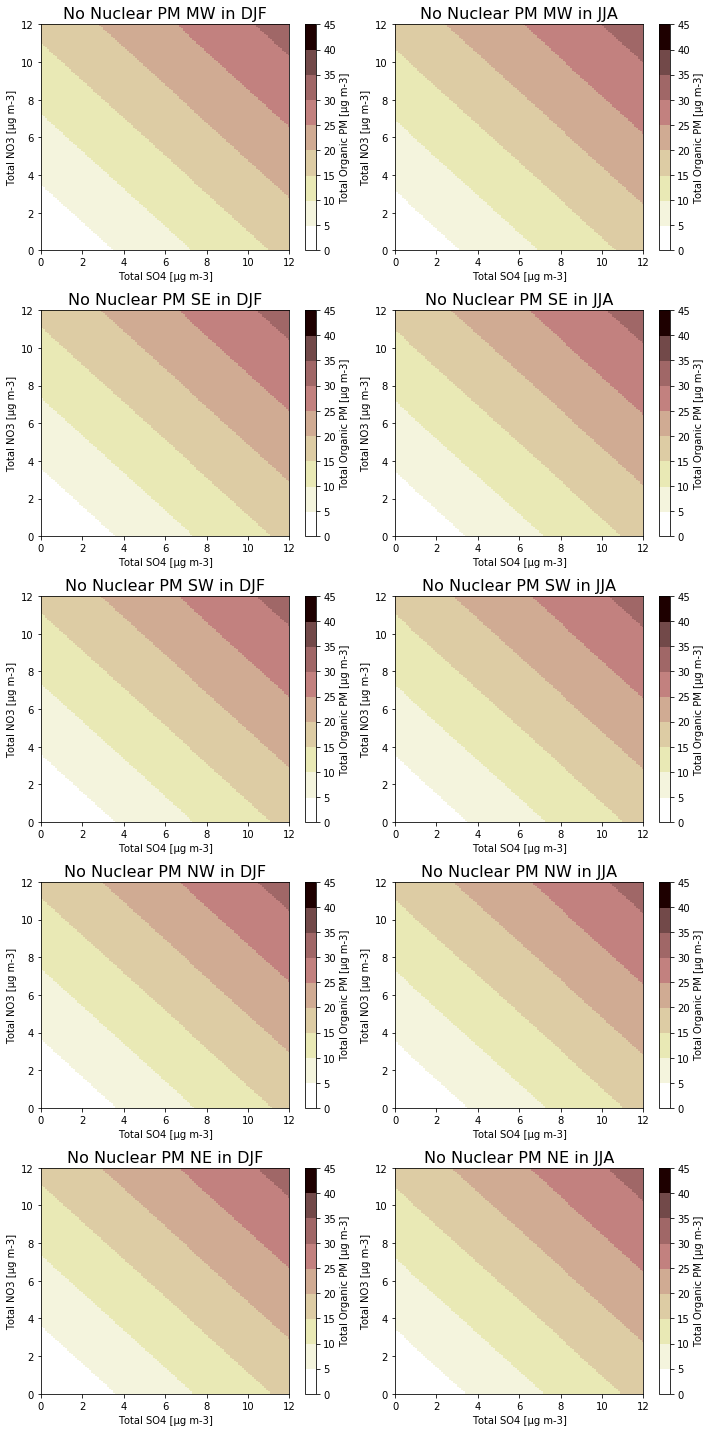

In [20]:
fig, axes = plt.subplots(5,2,figsize = [10,20])
for idx_r, region_name in enumerate(ds_isorropia['region_name'].values):
    for idx_s, season in enumerate(ds_isorropia['season'].values):
        ax = axes[idx_r,idx_s]
        ds_isorropia.sel(region_name = region_name, season = season).PM.plot(ax = ax, levels=10, cmap = 'pink_r')
        ax.set_title(f'No Nuclear PM {region_name} in {season}', fontsize = 16);
        ax.set_xlim(0,12)
        ax.set_ylim(0,12)
        plt.tight_layout()

## Import NIT and SO4 from observations and model

In [134]:
IMPROVE_obs_df = pd.read_csv('../model_validation/IMPROVE_df.csv', parse_dates = True)
interp_IMPROVE_df = pd.read_csv('../model_validation/interp_IMPROVE_df.csv', parse_dates = True)
IMPROVE_monthly_df = pd.read_csv('../model_validation/IMPROVE_monthly_obs_df.csv', parse_dates = True)

#change to datetime
IMPROVE_obs_df['date'] = pd.to_datetime(IMPROVE_obs_df['Date'], format = '%Y%m%d')
interp_IMPROVE_df['date'] = pd.to_datetime(interp_IMPROVE_df['date'])
IMPROVE_monthly_df['date'] = pd.to_datetime(IMPROVE_monthly_df['date'], format = '%Y%m%d')

#select only Lat and Lon on continental US
IMPROVE_obs_df = IMPROVE_obs_df.loc[(IMPROVE_obs_df['Latitude'].between(24,50,inclusive = True)) & (IMPROVE_obs_df['Longitude'].between(-130,-60,inclusive = True))]
interp_IMPROVE_df = interp_IMPROVE_df.loc[(interp_IMPROVE_df['Latitude'].between(24,50,inclusive = True)) & (interp_IMPROVE_df['Longitude'].between(-130,-60,inclusive = True))]
IMPROVE_monthly_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['latitude'].between(24,50,inclusive = True)) & (IMPROVE_monthly_df['longitude'].between(-130,-60,inclusive = True))]

In [135]:
for region in IMPROVE_monthly_df['Region'].unique():
    IMPROVE_monthly_df.loc[IMPROVE_monthly_df['Region'] == region, 'annual_T'] = RH_T_df.loc[region]['T'].mean()
    IMPROVE_monthly_df.loc[IMPROVE_monthly_df['Region'] == region, 'annual_RH'] = RH_T_df.loc[region]['RH'].mean()

In [136]:
IMPROVE_monthly_df['model'] = 'IMPROVE'
IMPROVE_monthly_df = IMPROVE_monthly_df.rename(columns = {'Latitude':'latitude','Longitude':'longitude'})

In [137]:
cdf = pd.concat([interp_IMPROVE_df, IMPROVE_monthly_df])   # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Region','model','species'],value_vars = ['Arithmetic Mean'])      # MELT

In [163]:
cdf.loc[(cdf['Region'] == 'NW_lat_lon')]['Region'].unique().item()

'NW_lat_lon'

In [176]:
regional_mean_df = pd.DataFrame(columns = {'Arithmetic Mean', 'latitude', 'longitude', 
                                   'species', 'date', 'model', 'region'})
for model in cdf['model'].unique():
    for region in cdf['Region'].unique():
        for species in ['NIT','PM25','SO4']:
            data = cdf.loc[(cdf['Region'] == region) & (cdf['species'] == species) & 
                    (cdf['model'] == model)].set_index('date').groupby(pd.Grouper(freq='M')).mean()
            tmp_df = pd.DataFrame({'Arithmetic Mean': data['Arithmetic Mean'], 'latitude':data['latitude'], 'longitude':data['longitude'], 
                                   'species': species, 'date': data.index, 'model':model, 'region':region})
            regional_mean_df = regional_mean_df.append(tmp_df, sort=False, ignore_index=True)

In [323]:
region = 'NE_lat_lon'
model = 'MODEL'
region_name = 'NE'

In [324]:
x = cdf.loc[(cdf['species'] == 'SO4') & (cdf['Region'] == region) & (cdf['model'] == model) & (cdf['date'].dt.month.isin([12,1,2]))]['Arithmetic Mean']
y = cdf.loc[(cdf['species'] == 'NIT') & (cdf['Region'] == region) & (cdf['model'] == model) & (cdf['date'].dt.month.isin([12,1,2]))]['Arithmetic Mean']
z = cdf.loc[(cdf['species'] == 'PM25') & (cdf['Region'] == region) & (cdf['model'] == model) & (cdf['date'].dt.month.isin([12,1,2]))]['Arithmetic Mean']


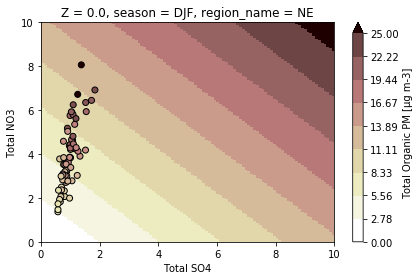

In [325]:
fig, ax = plt.subplots()
ds_isorropia.sel(region_name = region_name, season = 'DJF').PM.plot(ax = ax, levels=10, cmap = 'pink_r', vmin = 0, vmax = 25)
plt.scatter(x, y, c = z, cmap = 'pink_r', edgecolors = 'k', vmin = 0, vmax = 25);
plt.xlabel('Total SO4');
plt.ylabel('Total NO3');
plt.xlim([0,10])
plt.ylim([0,10])
plt.tight_layout()

In [283]:
dNit_dPM = (cdf.loc[(cdf['species'] == 'NIT') & (cdf['model'] == 'IMPROVE')]['Arithmetic Mean'] - 
            cdf.loc[(cdf['species'] == 'NIT') & (cdf['model'] == 'MODEL')]['Arithmetic Mean'])/(
            cdf.loc[(cdf['species'] == 'PM25') & (cdf['model'] == 'IMPROVE')]['Arithmetic Mean'] - 
            cdf.loc[(cdf['species'] == 'PM25') & (cdf['model'] == 'MODEL')]['Arithmetic Mean'])
